In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall --user
!pip install ffmpeg-python --user
# for converting to video

Skipping opencv-python as it is not installed.


  Using cached https://files.pythonhosted.org/packages/10/58/8433265d728cb603dc41c6ba04515c31ab14e490a55c4a654638e2ba9f6f/opencv_contrib_python-3.4.2.17-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9a/e3/56f6241cf309ff2f6d1df97fc0ba42a156526efa09261ee53f08521b7da3/numpy-1.21.4-cp37-cp37m-win_amd64.whl
  Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:


tables 3.5.1 requires mock>=2.0, which is not installed.
  The script f2py.exe is installed in 'C:\Users\tonyy\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


      Successfully uninstalled numpy-1.21.4
  Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17


In [2]:
import scipy
import scipy.sparse.linalg
import ffmpeg
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from skimage import draw
from multiprocessing import Pool, TimeoutError
import pickle
import os
from numpy.linalg import svd, inv

In [68]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%reload_ext autoreload
%autoreload 2
utilfn = "./utils.py"
import utils

In [ ]:
img = cv2.imread('./images/inputs/cat.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('./images/inputs/tiger.jpg')
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [ ]:
specify_new_points = True
write_back = True

In [ ]:
def specify_points(img):
    fig = plt.figure()
    fig.set_label('Select key matching points in the image')
    plt.axis('off')
    plt.imshow(img[:,:,[2,1,0]])
    H, W, C = img.shape
    clicked = [[0, 0], [0, W-1], [H-1, 0], [H-1, W-1]]
#     result = [1]
    
    def on_mouse_pressed(event, ps):
        x = round(event.xdata)
        y = round(event.ydata)
    #         plt.plot(x, y, 'ro')
        plt.clf()
        plt.imshow(img[:,:,[2,1,0]])
        ps.append([x, y])
        points = np.array(ps)
#         triangulation = Delaunay(points)
#         result[0] = triangulation
#         plt.triplot(points[:,0], points[:,1], triangulation.simplices, c='r')
        triang = tri.Triangulation(points[:,0], points[:,1])
        plt.triplot(triang, c='r')
        plt.plot(points[:,0], points[:,1], 'ro')
        
    fig.canvas.mpl_connect('button_press_event', lambda event: on_mouse_pressed(event, clicked))

    return clicked

In [ ]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def get_mask(triangle, img):
    ys = triangle[:,1]
    xs = triangle[:,0]
    mask = poly2mask(ys, xs, img.shape[:2])
#     fig = plt.figure()
#     plt.imshow(np.uint8(mask), cmap='gray')
    return mask

In [ ]:
if specify_new_points:
    %matplotlib notebook
    points = specify_points(img)
    print("Specify")
else:
    points = pickle.load(open('points.pkl', 'rb'))

In [ ]:
if specify_new_points:
    %matplotlib notebook
    points_2 = specify_points(img2)
    print("Specify")
else:
    points_2 = pickle.load(open('points_2.pkl', 'rb'))

In [ ]:
if write_back:
    pickle.dump(points, open('points.pkl', 'wb'))
    pickle.dump(points_2, open('points_2.pkl', 'wb'))

In [ ]:
points = np.array(points)
points_2 = np.array(points_2)
len(points)==len(points_2)

In [ ]:
%matplotlib inline
test = tri.Triangulation(points_2[:,0], points_2[:,1]).get_masked_triangles()
fig = plt.figure()
plt.imshow(img[:,:,[2,1,0]])
# triang = tri.Triangulation(points[:,0], points[:,1])
plt.triplot(points[:,0], points[:,1], test, c='r')
plt.plot(points[:,0], points[:,1], 'ro')
fig = plt.figure()
plt.imshow(img2[:,:,[2,1,0]])
# triang = tri.Triangulation(points[:,0], points[:,1])
plt.triplot(points_2[:,0], points_2[:,1], test, c='r')
plt.plot(points_2[:,0], points_2[:,1], 'ro')

In [ ]:
if __name__ == '__main__':
    points = np.array(points)
    points_2 = np.array(points_2)
    test = tri.Triangulation(points_2[:,0], points_2[:,1]).get_masked_triangles()
    duration = 3 # in seconds
    fps = 30
    num_frames = duration * fps
    pool = Pool()
    results = []
    positions = np.zeros(img.shape[:2],dtype=np.ndarray)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            positions[y,x]=[x,y]
    ori_tris = points[test]
    new_tris = points_2[test]
    ori_img = img
    new_img = img2
    argument = [(ori_tris, new_tris, frame_num / num_frames, ori_img,new_img,positions,frame_num, 'test5') for frame_num in range(0, num_frames)]

    result = pool.starmap(utils.generate_imgs, argument)
    print("here")

Idea 1: Cross-Dissolve

In [20]:
def crossDissolve(sourceImg, targetImg, timelength):
    assert sourceImg.shape == targetImg.shape
    video_name = 'crossDissolve.mp4'
    H, W, C = targetImg.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (W,H))
    #Imagehalfway = (1-t)*Image1 + t*image2
    timelengthfps = timelength * 30
    for i in range (timelengthfps):
        halfImg = (timelengthfps - i) / timelengthfps * sourceImg + i / timelengthfps * targetImg
        if i == timelength * 10:
            halfImg1 = halfImg
        if i == timelength * 20:
            halfImg2 = halfImg
        video.write(np.uint8(halfImg))
    cv2.destroyAllWindows()
    video.release()
    return halfImg1, halfImg2
    

In [21]:
sourceImg = cv2.imread('./images/inputs/river1.jpg')
targetImg = cv2.imread('./images/inputs/river2.jpg')

halfImg1, halfImg2 = crossDissolve(sourceImg, targetImg, 5)


In [22]:
sourceImg.shape[:2]

(208, 254)

Idea 2: Align, then cross-disolve!

In [23]:
def computeHomography(pts1, pts2,normalization_func=None):
    A = np.zeros((2*pts1.shape[1], 9))
    for i in range (A.shape[0]):
        i_2 = i//2
        if i % 2 == 0:
            A[i,0] = -pts1[0, i_2]
            A[i,1] = -pts1[1, i_2]
            A[i,2] = -1
            A[i,6] = pts1[0, i_2] * pts2[0, i_2]
            A[i,7] = pts1[1, i_2] * pts2[0, i_2]
            A[i,8] = pts2[0, i_2]
        else: 
            A[i,3] = -pts1[0, i_2]
            A[i,4] = -pts1[1, i_2]
            A[i,5] = -1
            A[i,6] = pts1[0, i_2] * pts2[1, i_2]
            A[i,7] = pts1[1, i_2] * pts2[1, i_2]
            A[i,8] = pts2[1, i_2]
    _, _, Vt = np.linalg.svd(A)
    Vt_end = Vt.shape[0]
    h = Vt[Vt_end-1, :]
    H = h.reshape(3,3)
    return H

In [24]:
targetfile = './images/inputs/bridge1.jpg'
targetImg = cv2.imread('./images/inputs/bridge1.jpg')
sourcefile = './images/inputs/bridge2.jpg'
sourceImg = cv2.imread('./images/inputs/bridge2.jpg')


In [25]:
def alignedCrossDissolve(sourceImg, targetImg, timelength):
    # H = utils.auto_homography(sourceImg,targetImg, computeHomography)
    # T = np.array([[1,0,100],[0,1,50],[0,0,1]])
    h, w, c = targetImg.shape
    # img_warped = cv2.warpPerspective(targetImg, np.dot(T,H), (4*w//3, 4*h//3))
    # background = np.uint8(np.zeros((4*h//3, 4*w//3, 3)))
    # background[:sourceImg.shape[0], :sourceImg.shape[1],:] = sourceImg
    
    background = targetImg
    img_warped = sourceImg
    
    video_name = 'alignedCrossDissolve.mp4'
    # video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (4*w//3, 4*h//3))
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (w, h))
    #Imagehalfway = (1-t)*Image1 + t*image2
    timelengthfps = timelength * 30
    plt.imshow(img_warped[:,:,[2,1,0]])
    plt.show()
    plt.imshow(background[:,:,[2,1,0]])
    plt.show()
    for i in range (timelengthfps):
        halfImg = np.uint8((timelengthfps - i) / timelengthfps * img_warped + i / timelengthfps * background)
        if i == timelength * 10:
            halfImg1 = halfImg
        if i == timelength * 20:
            halfImg2 = halfImg
        video.write(halfImg)
    cv2.destroyAllWindows()
    video.release()
    return halfImg1, halfImg2
    

<IPython.core.display.Javascript object>


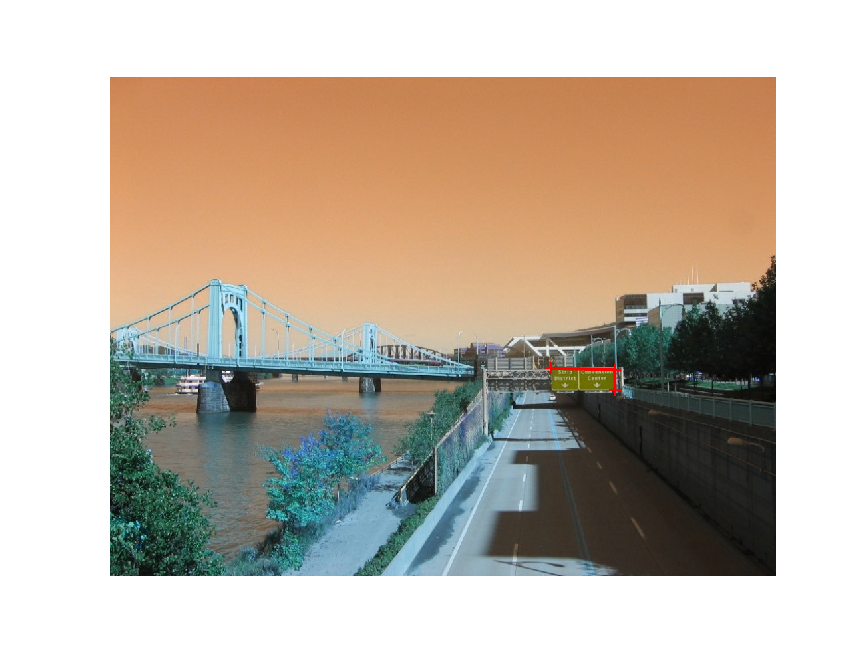

In [103]:
%matplotlib notebook  
pts_im2 = utils.prompt_eye_selection(sourceImg)
plt.imshow(sourceImg)

<IPython.core.display.Javascript object>


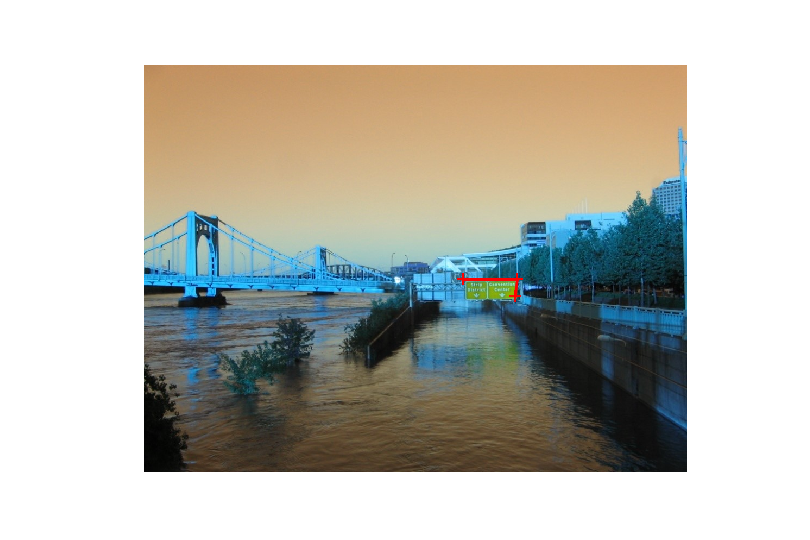

In [122]:
%matplotlib notebook
pts_im1 = utils.prompt_eye_selection(targetImg)
plt.imshow(targetImg)

In [28]:
%matplotlib inline
im1, im2 = utils.align_images(targetfile,sourcefile,pts_im1,pts_im2,save_images=False)
im2 = cv2.resize(im2, (im2.shape[1]//2, im2.shape[0]//2))
im1 = cv2.resize(im1, (im1.shape[1]//2, im1.shape[0]//2))

C:\Users\tonyy\iCloudDrive\University\Uni-UIUC\CS445\final_project_image_morphing-master\utils.py:158: RuntimeWarning: invalid value encountered in float_scalars
  dscale = len2 / len1


ValueError: cannot convert float NaN to integer

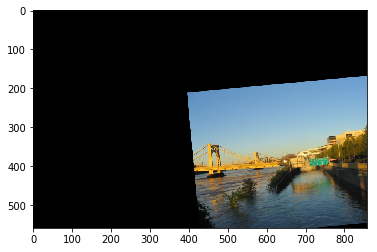

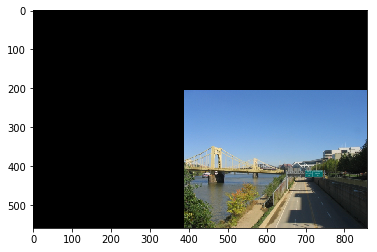

In [93]:
plt.imshow(im1[:,:,[2,1,0]])
plt.show()
plt.imshow(im2[:,:,[2,1,0]])
plt.show()

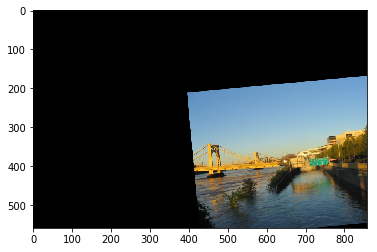

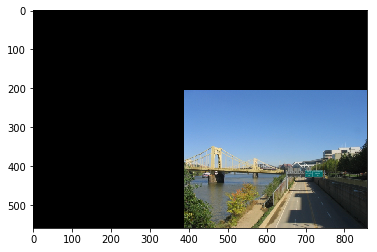

In [83]:
halfImg1, halfImg2 = alignedCrossDissolve(im1, im2, 5)

In [123]:
def alignedCrossDissolve(sourceImg, targetImg, timelength):
    H = utils.auto_homography(sourceImg,targetImg, computeHomography)
    T = np.array([[1,0,100],[0,1,50],[0,0,1]])
    h, w, c = targetImg.shape
    img_warped = cv2.warpPerspective(targetImg, np.dot(T,H), (4*w//3, 4*h//3))
    background = np.uint8(np.zeros((4*h//3, 4*w//3, 3)))
    background[:sourceImg.shape[0], :sourceImg.shape[1],:] = sourceImg
    
    #background = targetImg
    #img_warped = sourceImg
    
    video_name = 'alignedCrossDissolve.mp4'
    # video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (4*w//3, 4*h//3))
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (w, h))
    #Imagehalfway = (1-t)*Image1 + t*image2
    timelengthfps = timelength * 30
    plt.imshow(img_warped[:,:,[2,1,0]])
    plt.show()
    plt.imshow(background[:,:,[2,1,0]])
    plt.show()
    for i in range (timelengthfps):
        halfImg = np.uint8((timelengthfps - i) / timelengthfps * img_warped + i / timelengthfps * background)
        if i == timelength * 10:
            halfImg1 = halfImg
        if i == timelength * 20:
            halfImg2 = halfImg
        video.write(halfImg)
    cv2.destroyAllWindows()
    video.release()
    return halfImg1, halfImg2
    

<IPython.core.display.Javascript object>


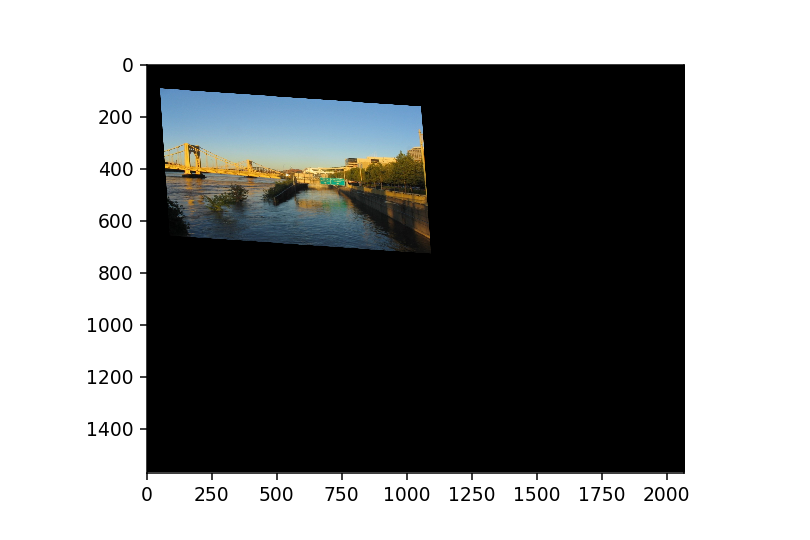

In [124]:
plt.imshow(targetImg[:,:,[2,1,0]])
plt.show()

In [125]:
hh,ww, cc = targetImg.shape
TT = np.float32([[0,1,100],[1,0,50]])
targetImg32 = np.float32(targetImg)
newtargetImg = uint8(cv2.warpAffine(targetImg32,TT, (hh,ww)))
print(np.max(newtargetImg))
plt.imshow(np.uint8(newtargetImg[:,:,[2,1,0]]))
plt.show()

NameError: name 'uint8' is not defined

<IPython.core.display.Javascript object>


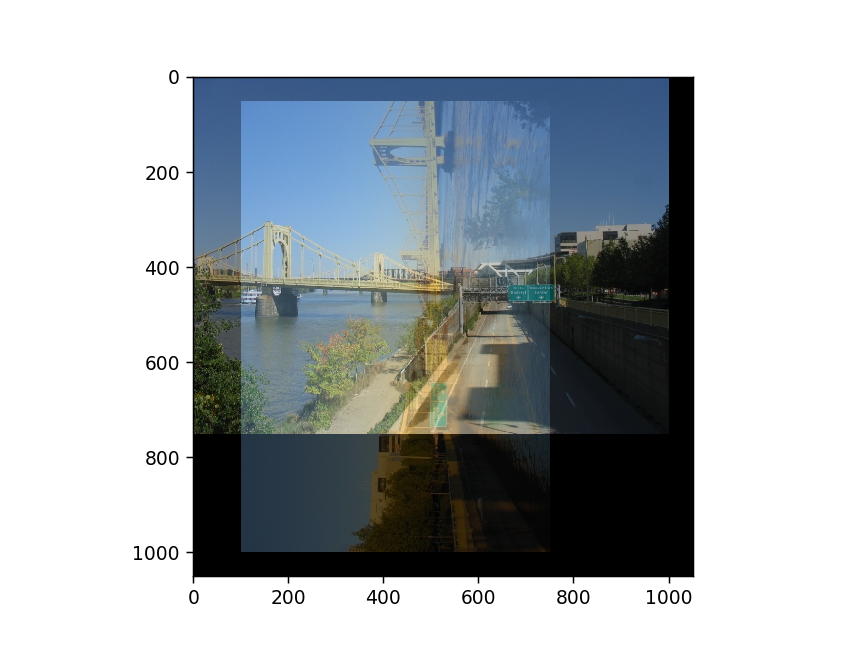

In [106]:
M = cv2.getAffineTransform(pts_im1, pts_im2)
dst = cv2.warpAffine(targetImg,M,(3*ww//2,3*hh//2))
plt.imshow(np.uint8(dst[:,:,[2,1,0]]))
plt.show()

In [126]:
maxW = max(dst.shape[1],sourceImg.shape[1])
maxH = max(dst.shape[0],sourceImg.shape[0])
a = np.uint8(cv2.copyMakeBorder(dst,0,50+maxH-dst.shape[0],0,50+maxW-dst.shape[1], cv2.BORDER_CONSTANT,value=[0,0,0]))
b = np.uint8(cv2.copyMakeBorder(sourceImg,0,50+maxH-sourceImg.shape[0],0,50+maxW-sourceImg.shape[1], cv2.BORDER_CONSTANT,value=[0,0,0]))
h1, h2 = alignedCrossDissolve(a,b,5)


best score: 15.000000


In [74]:
import utils

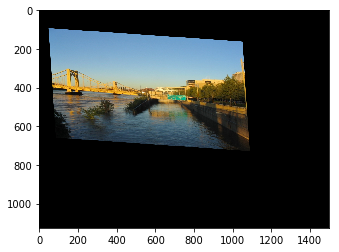

In [127]:
%matplotlib inline
plt.imshow(np.uint8(dst[:,:,[2,1,0]]))
plt.show()